In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.stats import norm
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
import seaborn as sns

we are going to simulate vasicek model parameter

$\Delta{rt}$ = $K(\theta - r_t)\Delta{t}+ \sigma{dwt}$ 

further:-

$rt = r_{t-1}e^{-K*t} + \theta(1-e^{-K*t}) + \epsilon$

where $\epsilon = \sigma\sqrt{t}$

thus:- $\mu = r_{t-1}e^{-K*t} + \theta(1-e^{-K*t})$  
$\sigma = \epsilon$


Now consider:- $e^{-K*t} = \alpha$  and $\theta(1-e^{-K*t}) = \beta$

thus revised equation woud be:- $rt = r_{t-1}*\alpha + \beta + \epsilon$  (This become AR(1) model and we can apply MLE or OLS here to derive parameter of $\\alpha$  and $ \\beta$

In [3]:
data = pd.read_csv(r"H:\Python Module\Practice\Interesr Rate modelling\Vasicek Model\3m_treasury_bill_interest_rates.csv")
data = data[["Date","Adj Close"]]
data

,Date,Adj Close
0,1/3/2000,5.270
1,1/4/2000,5.270
2,1/5/2000,5.270
3,1/6/2000,5.240
4,1/7/2000,5.220
...,...,...
6026,12/22/2023,5.208
6027,12/26/2023,5.203
6028,12/27/2023,5.235
6029,12/28/2023,5.218


In [4]:
data["Date"] = pd.to_datetime(data["Date"],yearfirst=True)


In [5]:
# Convert 'Adj Close' column to numeric, forcing any non-numeric values to NaN
data["Adj Close"] = pd.to_numeric(data["Adj Close"],errors="coerce")

data.dropna(inplace=True)

In [6]:
data["Adj Close"] = data["Adj Close"]/100
data.set_index("Date",inplace = True)


In [7]:
data.style.background_gradient(cmap ='BuGn')


,Adj Close
Date,
2000-01-03 00:00:00,0.052700
2000-01-04 00:00:00,0.052700
2000-01-05 00:00:00,0.052700
2000-01-06 00:00:00,0.052400
2000-01-07 00:00:00,0.052200
2000-01-10 00:00:00,0.052300
2000-01-11 00:00:00,0.052700
2000-01-12 00:00:00,0.052800
2000-01-13 00:00:00,0.052200


In [8]:
print(data.head())

            Adj Close
Date                 
2000-01-03     0.0527
2000-01-04     0.0527
2000-01-05     0.0527
2000-01-06     0.0524
2000-01-07     0.0522


In [9]:
# calculating rolling mean and rolling standard deviation:-

rolling_mean = data['Adj Close'].rolling(12).mean()
rolling_std = data["Adj Close"].rolling(12).std()

# clean NaN values for plotting

clean_rolling_mean = rolling_mean.dropna()
clean_rolling_std = rolling_std.dropna()

# Scale the rolling standard deviation for better visibility

scaled_rolling_std = clean_rolling_std*6



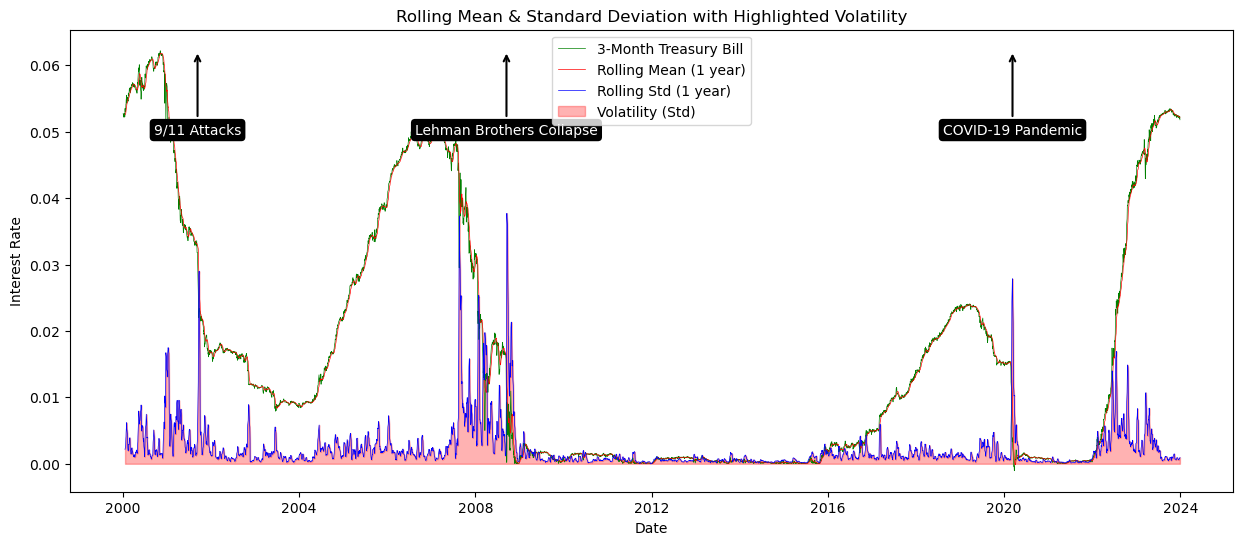

In [10]:
events = [
    ('2001-09-11', '9/11 Attacks'),
    ('2008-09-15', 'Lehman Brothers Collapse'),
    ('2020-03-11', 'COVID-19 Pandemic')]



ymax = data['Adj Close'].max()
plt.figure(figsize = (15,6))
plt.plot(data.index,data["Adj Close"],lw =0.5,color ="green",label="3-Month Treasury Bill")
plt.plot(clean_rolling_mean.index,clean_rolling_mean,lw=0.5,color = "red",label = "Rolling Mean (1 year)")
plt.plot(scaled_rolling_std.index,scaled_rolling_std,lw=0.5,color = "blue",label = "Rolling Std (1 year)")
plt.fill_between(scaled_rolling_std.index,scaled_rolling_std,0,color='red',alpha=0.3,label='Volatility (Std)')              
for date, label in events:
    plt.annotate(
        label,
        xy=(pd.Timestamp(date), ymax),
        xytext=(0, -60),                    # ax=0, ay=-60
        textcoords='offset points',
        arrowprops=dict(
            arrowstyle='->',
            color='black',
            linewidth=1.5),
        bbox=dict(boxstyle='round,pad=0.3',
            facecolor='black',
            edgecolor='none'),color='white',ha='center')





plt.xlabel("Date")
plt.ylabel("Interest Rate")
plt.title("Rolling Mean & Standard Deviation with Highlighted Volatility")
plt.legend(loc="best")
plt.show()

In [11]:
data_monthly = data.resample('M').mean()
data_monthly = data_monthly.reset_index()
data_monthly['Month'] = data_monthly['Date'].dt.month

In [12]:
data_monthly

,Date,Adj Close,Month
0,2000-01-31,0.053125,1
1,2000-02-29,0.055480,2
2,2000-03-31,0.056887,3
3,2000-04-30,0.056516,4
4,2000-05-31,0.057823,5
...,...,...,...
283,2023-08-31,0.052832,8
284,2023-09-30,0.053015,9
285,2023-10-31,0.053225,10
286,2023-11-30,0.052566,11


In [13]:
# define initial interest rate

r0 = data.iloc[0]

# define vasicek_log-likelihood()

def vasicek_log_likelihood(data,alpha,beta,sigma):
    # alpha,beta,sigma= param
    if sigma <= 0 or alpha <= 0:
        return np.inf
    dt = 1/252
    r_t = data[:-1]
    r_t1 = data[1:]
    
    
    
    drift = alpha*(beta-r_t)*dt
    diffusion = sigma*np.sqrt(dt)
    error = r_t1 - r_t - drift
    #log_likelihood = np.sum(-np.log(norm.pdf(error,0,sigma*np.sqrt(dt))))
    log_likelihood = -0.5*np.sum((2*np.pi*diffusion*diffusion) + ((r_t1 - r_t-drift)**2)/(diffusion**2))
    
    return log_likelihood
    
def vasicek_MLE(param,data):
    log_likelihood = vasicek_log_likelihood(data,*param)
    return -log_likelihood

In [14]:
initial_params = [0.18211131505560754, 0.0, 0.009454867809470299]

result = minimize(vasicek_MLE,initial_params,args=(data.values,),bounds=((None,None),(None,None),(None,None)))
result.x                                                   

array([0.08355474, 0.01608322, 0.21561614])

In [15]:
def VasicekCallibration(rates_,dt = 1/252):
    rates = rates_.copy()
    #rates = rates.iloc[:,-1]
    rates["Leg_1"] = rates.iloc[:,0].shift(1)
    rates.dropna(inplace=True)
    #rates.drop(columns=["S.No"],inplace=True)
    #rates.set_index("Date")
    y = rates["Adj Close"]
    x = rates["Leg_1"]
    X = sm.add_constant(x)
    ## OLS estimator
    OLS = np.linalg.inv(X.T@X)@X.T@y
    
    rates["modeled"] = OLS[0] + OLS[1]*x
    rates["residual"] = y- rates["modeled"]
    kappa = -np.log(OLS[1])/dt
    theta = OLS[0]/(1-OLS[1])
    ## caculating Variance
    RSS = (rates["residual"]**2).sum()
    MSE = RSS/(len(rates["residual"])-2)
    sigma_e = np.sqrt(MSE)
    sigma = sigma_e/np.sqrt(dt)
    
    r0 = rates.iloc[len(rates["residual"])-1,1]
    return kappa,theta,sigma

In [16]:
alpha,theta,sigma=VasicekCallibration(data,dt=1/252)
alpha,theta,sigma

(0.0835648015247878, 0.01608148157810157, 0.007342179712934243)

In [51]:
# Ensure the variable num_simulations is defined
num_simulations = 10
num_days = 3*252

def vasicek_simulations(r0, alpha, theta, sigma, num_days, num_simulations):
    sim_result =[]
    dt =1/252
    rates=np.zeros((num_days+1,num_simulations))
    
    rates[0] = r0
    #print(rates)
    for t in range(1,num_days):
        rates[t] =  rates[t-1] + alpha*(theta-rates[t-1])*dt + sigma*np.sqrt(dt)*np.random.standard_normal(num_simulations)
        
    return rates
    
#rates=np.zeros((num_days,num_simulations))


#M = [N/252 for N in range(0,num_days+1)]

dates = data.index[-1] +pd.Timedelta(days=1)

simulated_dates = pd.date_range(start=dates,periods=num_days,freq="D")
int_sim = vasicek_simulations(data["Adj Close"][-1],alpha,theta,sigma,num_days,num_simulations)
#print(dates)
#print(data.index[-1])
simulated_dates= simulated_dates.insert(0,data.index[-1])
simulated_dates

DatetimeIndex(['2023-12-29', '2023-12-30', '2023-12-31', '2024-01-01',
               '2024-01-02', '2024-01-03', '2024-01-04', '2024-01-05',
               '2024-01-06', '2024-01-07',
               ...
               '2026-01-14', '2026-01-15', '2026-01-16', '2026-01-17',
               '2026-01-18', '2026-01-19', '2026-01-20', '2026-01-21',
               '2026-01-22', '2026-01-23'],
              dtype='datetime64[ns]', length=757, freq='D')

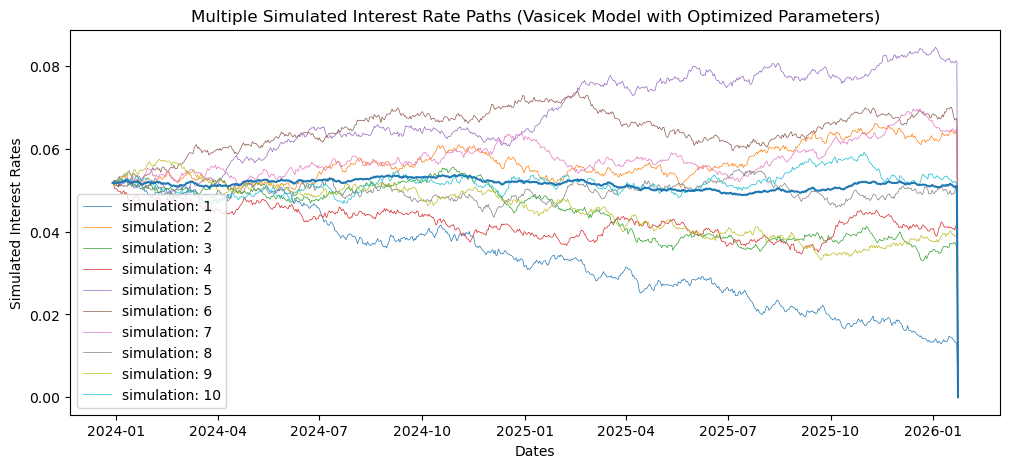

In [92]:
label_= []
for i in np.arange(1,11):
    label_.append(f"simulation: {i}")
    

plt.figure(figsize= (12,5))
plt.plot(simulated_dates,int_sim,lw=0.5,label=label_)
plt.plot(simulated_dates,int_sim.mean(axis = 1))
plt.title('Multiple Simulated Interest Rate Paths (Vasicek Model with Optimized Parameters)')
plt.xlabel("Dates")
plt.ylabel("Simulated Interest Rates")
plt.legend(loc="best")
plt.show()

In [55]:
simulatd_df_opt = pd.DataFrame(int_sim,index=simulated_dates)
simulatd_df_opt

,0,1,2,3,4,5,6,7,8,9
2023-12-29,0.051800,0.051800,0.051800,0.051800,0.051800,0.051800,0.051800,0.051800,0.051800,0.051800
2023-12-30,0.052197,0.052150,0.052320,0.051416,0.051746,0.051257,0.052169,0.052226,0.051276,0.051586
2023-12-31,0.052271,0.052360,0.052344,0.050380,0.051413,0.052148,0.051816,0.052412,0.051024,0.051959
2024-01-01,0.052333,0.052380,0.051952,0.050400,0.051134,0.051784,0.051940,0.052288,0.051765,0.052124
2024-01-02,0.052364,0.052050,0.051848,0.050281,0.051262,0.051144,0.052527,0.052190,0.052488,0.051901
...,...,...,...,...,...,...,...,...,...,...
2026-01-19,0.013818,0.064131,0.037193,0.040820,0.080841,0.067889,0.064385,0.049075,0.039326,0.052154
2026-01-20,0.013364,0.063619,0.037453,0.040442,0.080852,0.066971,0.064243,0.049596,0.038840,0.052198
2026-01-21,0.013304,0.064005,0.036865,0.041342,0.081276,0.067305,0.064546,0.050681,0.039100,0.051796
2026-01-22,0.012632,0.064628,0.036275,0.041675,0.081185,0.067320,0.065180,0.050900,0.039255,0.051799
